In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import cmocean
import textwrap
import metpy.calc as mpcalc
from metpy.units import units

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmap


ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
region = 'baja' ## 'san_juan' 'baja' 'gulf_of_mexico'
## create bounding boxes for regions
d = {'baja': {'ext': [-115., -110., 27., 32.],
              'start_pt': [33.0, -118.],
              'end_pt': [29.0, -110.]},
     
     'san_juan': {'ext': [-109., -105., 37., 39.],
              'start_pt': [38.0, -112.],
              'end_pt': [38.0, -102.]},

     'gulf_of_mexico': {'ext': [-99., -93., 25., 31.],
              'start_pt': [28.0, -100.],
              'end_pt': [31.0, -93.]}
    }

## load dates to subset to 
fname_out = '../out/line_dates_{0}.csv'.format(region)

In [4]:
## iterate through options
varname = 'uvwq'
region_lst = ['baja']
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']
ext = [-140., -90., 20, 50]

tmp_lst = []
for i, region in enumerate(region_lst):  
    ds_lst = []
    for j, ssn in enumerate(ssn_lst):
        ## load non-anomaly composite data
        path = '/home/dnash/DATA/preprocessed/ERA5_composites/cross_section/'
        fname = path + 'composite_{0}_{1}_{2}.nc'.format(varname, ssn, region)
    
        ds = xr.open_dataset(fname)
        ds_lst.append(ds)

    ## concat ds_lst along ssn
    tmp = xr.concat(ds_lst, pd.Index(ssn_lst, name="ssn"))
    tmp_lst.append(tmp)

## get first dataset
ds = tmp_lst[0]
ds


<xarray.Dataset>
Dimensions:    (location: 17, level: 23, ssn: 6)
Coordinates:
    longitude  (location) float32 -118.0 -117.5 -117.0 ... -111.0 -110.5 -110.0
    latitude   (location) float32 33.0 32.75 32.5 32.25 ... 29.5 29.25 29.0
  * level      (level) int32 1000 975 950 925 900 875 ... 350 300 250 225 200
  * ssn        (ssn) object 'DJF' 'MAM' 'JJA' 'SON' 'NDJFMA' 'MJJASO'
Dimensions without coordinates: location
Data variables:
    q          (ssn, level, location) float32 0.007019 0.007054 ... 3.446e-05
    u          (ssn, level, location) float32 2.378 2.133 0.8591 ... 18.83 18.19
    v          (ssn, level, location) float32 1.588 2.396 1.925 ... 8.57 7.976
    w          (ssn, level, location) float32 -0.02639 -0.02737 ... -0.01789

In [6]:
## add wvflux data
qu = ds.q*ds.u
qv = ds.q*ds.v
ds = ds.assign(wvflux=np.sqrt(qu**2 + qv**2))
ds

<xarray.Dataset>
Dimensions:    (location: 17, level: 23, ssn: 6)
Coordinates:
    longitude  (location) float32 -118.0 -117.5 -117.0 ... -111.0 -110.5 -110.0
    latitude   (location) float32 33.0 32.75 32.5 32.25 ... 29.5 29.25 29.0
  * level      (level) int32 1000 975 950 925 900 875 ... 350 300 250 225 200
  * ssn        (ssn) object 'DJF' 'MAM' 'JJA' 'SON' 'NDJFMA' 'MJJASO'
Dimensions without coordinates: location
Data variables:
    q          (ssn, level, location) float32 0.007019 0.007054 ... 3.446e-05
    u          (ssn, level, location) float32 2.378 2.133 0.8591 ... 18.83 18.19
    v          (ssn, level, location) float32 1.588 2.396 1.925 ... 8.57 7.976
    w          (ssn, level, location) float32 -0.02639 -0.02737 ... -0.01789
    wvflux     (ssn, level, location) float32 0.02007 0.02263 ... 0.0006846

In [7]:
x = ds.longitude
y = ds.latitude
print(x)

<xarray.DataArray 'longitude' (location: 17)>
array([-118. , -117.5, -117. , -116.5, -116. , -115.5, -115. , -114.5,
       -114. , -113.5, -113. , -112.5, -112. , -111.5, -111. , -110.5,
       -110. ], dtype=float32)
Coordinates:
    longitude  (location) float32 -118.0 -117.5 -117.0 ... -111.0 -110.5 -110.0
    latitude   (location) float32 33.0 32.75 32.5 32.25 ... 29.5 29.25 29.0
Dimensions without coordinates: location
Attributes:
    units:      degrees_east
    long_name:  longitude


In [8]:
## now load zero degree level data
fname = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5/zero_degree_level/2022_deg0l.nc'
deg0l = xr.open_dataset(fname)
deg0l = deg0l.sel(time='2022-12-31 19', longitude=x+360, latitude=y, method='nearest') # subset to points
heights = units.Quantity(deg0l.deg0l.values, "m") ## add units to freezing level
deg0l = mpcalc.height_to_pressure_std(heights).magnitude # convert from m to hPa
deg0l

array([625.3564 , 624.8493 , 638.69495, 684.0528 , 727.0115 , 664.42255,
       632.19293, 599.654  , 599.2251 , 599.3782 , 599.3859 , 627.03796,
       635.4291 , 638.96106, 610.3768 , 610.22144, 630.6995 ],
      dtype=float32)

In [9]:
## now load surface pressure data
fname = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5/surface_pressure/2022_sp.nc'
sp = xr.open_dataset(fname)
sp = sp.sel(time='2022-12-31 19', longitude=x+360, latitude=y, method='nearest')
sp

<xarray.Dataset>
Dimensions:    (location: 17)
Coordinates:
    latitude   (location) float32 33.0 32.75 32.5 32.25 ... 29.5 29.25 29.0
    longitude  (location) float32 242.0 242.5 243.0 243.5 ... 249.0 249.5 250.0
    time       datetime64[ns] 2022-12-31T19:00:00
Dimensions without coordinates: location
Data variables:
    sp         (location) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      Thu Apr  4 08:59:34 2024: ncks -O --mk_rec_dmn time /data/p...
    NCO:          netCDF Operators version 5.2.2 (Homepage = http://nco.sf.ne...

In [10]:
sp.sp.values

array([101020.78 , 101053.33 ,  99096.125,  93086.414,  87154.11 ,
        94217.63 ,  98724.92 , 100798.234, 100968.   , 100953.93 ,
       101019.91 ,  97023.69 ,  93915.03 ,  93833.23 ,  95808.91 ,
        95633.86 ,  93084.66 ], dtype=float32)

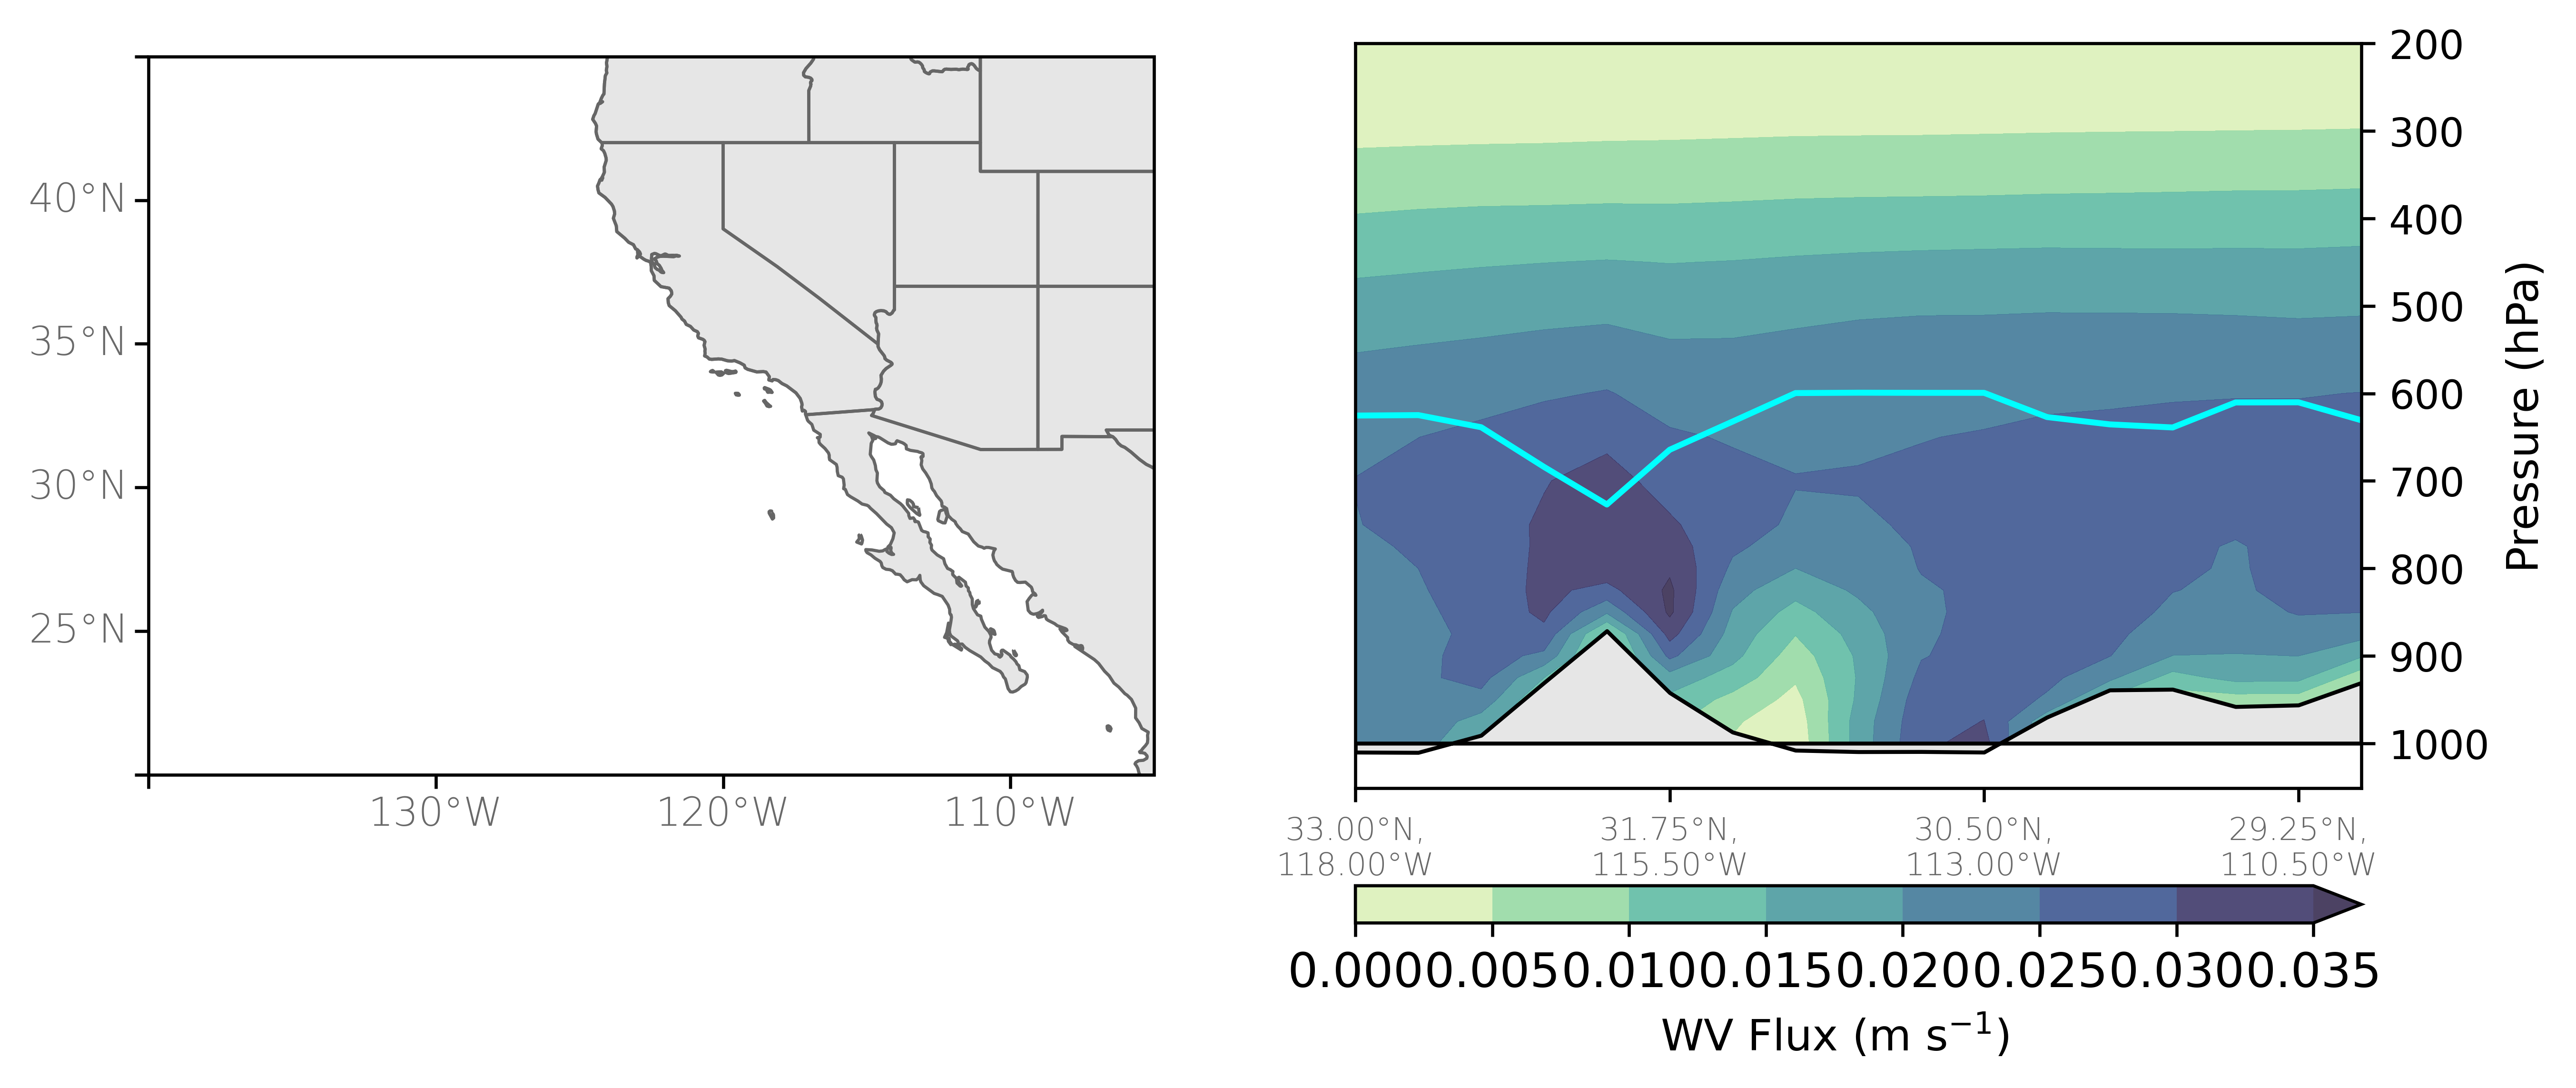

In [16]:
nrows = 2
ncols = 2
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05], width_ratios = [1, 1], wspace=0.2, hspace=0.25)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(10.0, 4.0))
fig.dpi = 600
fname = path_to_figs + 'Jan2023_case_trajectory'
fmt = 'png'

############################
### PLOT IVT VALUES ###
############################
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in
ext = [-140., -105., 20., 45.]
# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)
## topo with gray shading
# cs = plot_terrain(ax, ext)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

# # add point where trajectory crosses transect
# ax.scatter(ds.longitude.values[0][0][29], ds.latitude.values[0][0][29], c='k', marker='.', transform=datacrs, alpha=1, s=40)

# ## add trajectory points, colored by pressure
# data = ds
# y_lst = data.latitude.values
# x_lst = data.longitude.values
# z_lst = data.level.values
# # ax.plot(x_lst, y_lst, c='gray', transform=datacrs, alpha=0.2)
# cmap, norm, bnds = ccmap.cmap('pressure')
# cf = ax.scatter(x_lst, y_lst, c=z_lst, cmap=cmap, norm=norm, marker='.', transform=datacrs, alpha=0.8, s=30)

# ## add elevation cross section points
# # cf2 = ax.scatter(test.longitude.values, test.latitude.values, c='k', marker='.', transform=datacrs, alpha=0.8, s=30)
# ax.plot(test.longitude.values, test.latitude.values, c='k', transform=datacrs, alpha=0.7)

# # Add color bar
# # cbarticks = norm[::1]
# cbax = plt.subplot(gs[1,0]) # colorbar axis
# cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
# cb.set_label('Pressure (hPa)', fontsize=11)
# cb.ax.tick_params(labelsize=12)

## mock up a vertical cross section
## y-axis is pressure
## x-axis are the points
ax = fig.add_subplot(gs[0, 1])
xs = np.arange(0, len(ds.location), 1) # how many coordinate values
ys = ds.level.values
# terline = test.values
terline = sp.sp.values / 100
ht_fill = ax.fill_between(xs, 1000, terline, facecolor='0.9', edgecolor='k', zorder=10)

# Filled contours (WV flux)
cflevs = np.arange(0., 0.04, 0.005)
clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
data = ds.wvflux.sel(ssn='DJF')
cf = ax.contourf(xs, ys, data, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)
plt.gca().invert_yaxis()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel("Pressure (hPa)", fontsize=11)

# ## add trajectory point
# x = 9
# y = ds.level.values[0][0][29]
# ax.scatter(x, y, c='k', marker='.',  alpha=1, s=40)

## add freezing level
freeze_line = ax.plot(xs, deg0l, c='cyan', lw=1.5)

x_ticks = np.arange(len(xs))
x_labels = [u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(ds.latitude.values[i], ds.longitude.values[i]*-1) for i in x_ticks]
# set the frequency of xtick labels
skip = 5
ax.set_xticks(x_ticks[0::skip])
ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[0::skip]], fontsize=6, **kw_ticklabels)

# Add color bar
# cbarticks = norm[::1]
cbax = plt.subplot(gs[1,1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('WV Flux (m s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()